# Sprawozdanie z **Obliczeń ewolucyjnych**
## Zadanie 2 

# Konfiguracja
Przy pomocy klasy Config można wybrać zastosowany algorytm oraz określić jego parametry:    
- w - współczynnik zmęczenia.   
- c1 - współczynnik przyspieszenia w kierunku własnego minimum cząstki
- c2 - współczynnik przyspieszenia w kierunku globalnego minimum cząstek
- iterations - ilość iteracji algorytmu  
- target_error - najniższy stopień błędu - po osiągnięciu tego wyniku algorytm zatrzymuje się  
- n_particles - ilość cząstek  
- arguments_dimensions - liczba wymiarów, w których rozkładane są cząsteczki   
- d_min - minimalna wartość współrzędnej dla każdego z wymiarów   
- d_max - maksymalna wartość współrzędnej dla każdego z wymiarów   
- fitness - wybór funkcji dostosowującej położenie cząstek         
 Dla celów badawczych, w dalszej części zaprezentowane są różne zestawy wartości konfiguracyjnych.

In [1]:
!pip install deap > /dev/null
# !pip install k3d > /dev/null
%matplotlib notebook
from pathlib import Path
import json

class Config(object):
    def __init__(self, CHI, C, DIST, DIMS, NSWARMS, NPARTICLES, NEXCESS, RCLOUD):
        self.CHI = CHI
        self.C = C
        self.DIST = DIST
        self.DIMS = DIMS
        self.NSWARMS = NSWARMS
        self.NPARTICLES = NPARTICLES
        self.NEXCESS = NEXCESS
        self.RCLOUD = RCLOUD

def as_config(dct):
    return Config(
        dct['CHI'],
        dct['C'],
        dct['DIST'],
        dct['DIMS'],
        dct['NSWARMS'],
        dct['NPARTICLES'], 
        dct['NEXCESS'], 
        dct['RCLOUD'],
        )

#default config
json_config ="""
{
    "CHI": 0.729843788,
    "C": 2.05,
    "DIST": "nuvd",
    "DIMS": 5,
    "NSWARMS": 1,
    "NPARTICLES": 5,
    "NEXCESS": 3,
    "RCLOUD": 0.5
}"""

# Algorytm MPSO

### Imports

In [2]:
#deap
import itertools
import math
import operator
import random

import numpy
np = numpy
from deap import base
from deap.benchmarks import movingpeaks
from deap import creator
from deap import tools

#plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

#random
from numpy import random as nrand
nrand.seed(0)
from random import seed
seed(0)

### Creator

In [3]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    best=None, bestfit=creator.FitnessMax)
creator.create("Swarm", list, best=None, bestfit=creator.FitnessMax)

def generate(pclass, dim, pmin, pmax, smin, smax):
    part = pclass(random.uniform(pmin, pmax) for _ in range(dim)) 
    part.speed = [random.uniform(smin, smax) for _ in range(dim)]
    return part

### Update particles

In [4]:
def convertQuantum(swarm, rcloud, centre, dist):
    dim = len(swarm[0])
    for part in swarm:
        position = [random.gauss(0, 1) for _ in range(dim)]
        dist = math.sqrt(sum(x**2 for x in position))
        
        if dist == "gaussian":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]
        
        elif dist == "uvd":
            u = random.random()
            part[:] = [(rcloud * x * u**(1.0/dim) / dist) + c for x, c in zip(position, centre)]
        
        elif dist == "nuvd":
            u = abs(random.gauss(0, 1.0/3.0))
            part[:] = [(rcloud * x * u / dist) + c for x, c in zip(position, centre)]
        
        del part.fitness.values
        del part.bestfit.values
        part.best = None
    
    return swarm

def updateParticle(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))

### Toolbox

In [5]:
def setup_toolbox(BOUNDS, mpb):    
    toolbox = base.Toolbox()
    toolbox.register("particle", generate, creator.Particle, dim=cfg.DIMS,
        pmin=BOUNDS[0], pmax=BOUNDS[1], smin=-(BOUNDS[1] - BOUNDS[0])/2.0,
        smax=(BOUNDS[1] - BOUNDS[0])/2.0)
    toolbox.register("swarm", tools.initRepeat, creator.Swarm, toolbox.particle)
    toolbox.register("update", updateParticle, chi=cfg.CHI, c=cfg.C)
    toolbox.register("convert", convertQuantum, dist=cfg.DIST)
    toolbox.register("evaluate", mpb)
    return toolbox

### App

In [6]:
class App():
    def run(self):
        verbose=True
        scenario = movingpeaks.SCENARIO_2
        BOUNDS = [scenario["min_coord"], scenario["max_coord"]]
        mpb = movingpeaks.MovingPeaks(dim=cfg.DIMS, **scenario)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", numpy.mean)
        stats.register("std", numpy.std)
        stats.register("min", numpy.min)
        stats.register("max", numpy.max)        
        stats.register("hist", lambda a: numpy.histogram(a, bins="auto"))


        logbook = tools.Logbook()
        logbook.header = "gen", "nswarm", "evals", "error", "offline_error", "avg", "max", "hist"

        # Generate the initial population
        population = [toolbox.swarm(n=cfg.NPARTICLES) for _ in range(cfg.NSWARMS)]

        # Evaluate each particle
        for swarm in population:
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)

                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])          # Get the position
                    part.bestfit.values = part.fitness.values   # Get the fitness
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])         # Get the position
                    swarm.bestfit.values = part.fitness.values  # Get the fitness

        record = stats.compile(itertools.chain(*population))
        logbook.record(gen=0, evals=mpb.nevals, nswarm=len(population),
                       error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

#         if verbose:
#             print(logbook.stream)

        generation = 1
        while mpb.nevals < 5e5:
            # Check for convergence
            rexcl = (BOUNDS[1] - BOUNDS[0]) / (2 * len(population)**(1.0/cfg.DIMS))

            not_converged = 0
            worst_swarm_idx = None
            worst_swarm = None
            for i, swarm in enumerate(population):
                # Compute the diameter of the swarm
                for p1, p2 in itertools.combinations(swarm, 2):
                    d = math.sqrt(sum((x1 - x2)**2. for x1, x2 in zip(p1, p2)))
                    if d > 2*rexcl:
                        not_converged += 1
                        # Search for the worst swarm according to its global best
                        if not worst_swarm or swarm.bestfit < worst_swarm.bestfit:
                            worst_swarm_idx = i
                            worst_swarm = swarm
                        break

            # If all swarms have converged, add a swarm
            if not_converged == 0:
                population.append(toolbox.swarm(n=cfg.NPARTICLES))
            # If too many swarms are roaming, remove the worst swarm
            elif not_converged > cfg.NEXCESS:
                population.pop(worst_swarm_idx)

            # Update and evaluate the swarm
            for swarm in population:
                # Check for change
                if swarm.best and toolbox.evaluate(swarm.best) != swarm.bestfit.values:
                    # Convert particles to quantum particles
                    swarm[:] = toolbox.convert(swarm, rcloud=cfg.RCLOUD, centre=swarm.best)
                    swarm.best = None
                    del swarm.bestfit.values

                for part in swarm:
                    # Not necessary to update if it is a new swarm
                    # or a swarm just converted to quantum
                    if swarm.best and part.best:
                        toolbox.update(part, swarm.best)
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not swarm.best or part.fitness > swarm.bestfit:
                        swarm.best = toolbox.clone(part[:])
                        swarm.bestfit.values = part.fitness.values

            record = stats.compile(itertools.chain(*population))
            logbook.record(gen=generation, evals=mpb.nevals, nswarm=len(population),
                           error=mpb.currentError(), offline_error=mpb.offlineError(), **record)

#             if verbose:
#                 print(logbook.stream)

            # Apply exclusion
            reinit_swarms = set()
            for s1, s2 in itertools.combinations(range(len(population)), 2):
                # Swarms must have a best and not already be set to reinitialize
                if population[s1].best and population[s2].best and not (s1 in reinit_swarms or s2 in reinit_swarms):
                    dist = 0
                    for x1, x2 in zip(population[s1].best, population[s2].best):
                        dist += (x1 - x2)**2.
                    dist = math.sqrt(dist)
                    if dist < rexcl:
                        if population[s1].bestfit <= population[s2].bestfit:
                            reinit_swarms.add(s1)
                        else:
                            reinit_swarms.add(s2)

            # Reinitialize and evaluate swarms
            for s in reinit_swarms:
                population[s] = toolbox.swarm(n=cfg.NPARTICLES)
                for part in population[s]:
                    part.fitness.values = toolbox.evaluate(part)

                    # Update swarm's attractors personal best and global best
                    if not part.best or part.fitness > part.bestfit:
                        part.best = toolbox.clone(part[:])
                        part.bestfit.values = part.fitness.values
                    if not population[s].best or part.fitness > population[s].bestfit:
                        population[s].best = toolbox.clone(part[:])
                        population[s].bestfit.values = part.fitness.values
            generation += 1
        return logbook

### Plots

In [125]:
flatten = lambda l: [item for sublist in l for item in sublist]

def hist_over_time(result_book, single_gen_index=None):
    print(len(result_book.select("hist")))
    hists = result_book.select("hist")
    hists = hists[100:] # skip first 100 evals
    hists = hists[0::4] # take one in 4
    hists = [h for h in hists if h]
    all_z_points = flatten([a[0].tolist() for a in hists])
    all_x_points = flatten([((a[1][1:] + a[1][:-1])/2).tolist() for a in hists])
    all_y_points = flatten([np.full(len(x[1]), x[0]) for x in [(a,hists[a][0]) for a in range(len(hists))]])
    size =  len(all_z_points)
    p = 0
    while p < size:
        if all_z_points[p] < 5:
            del all_z_points[p]
            del all_x_points[p]
            del all_y_points[p]
            size = size - 1
            p = p - 1
        p = p + 1
#     print(f"{len(all_z_points)} = {len(all_x_points)} = {len(all_y_points)}")
#     print(all_z_points[0:10])
#     print(all_x_points[0:10])
#     print(all_y_points[0:10])
    fig = plt.figure(figsize=(20, 6), dpi=100)
    ax = plt.axes(projection="3d")
    ax.scatter3D(all_x_points, all_y_points, all_z_points, c=all_z_points, cmap='inferno');
    ax.set_xlim(-250, 70)
    plt.show()

    if single_gen_index:
        res = np.array(resultBook.select("hist")[single_gen_index])
        z_points = res[0]
        x_points = (res[1][1:] + res[1][:-1])/2
        print(x_points)
        y_points = np.zeros(len(z_points))
        fig = plt.figure()
        ax = plt.axes(projection="3d")
        print(f"{len(z_points)} = {len(x_points)} = {len(y_points)}")
        ax.scatter3D(x_points, y_points, z_points, c=y_points, cmap='inferno');
        plt.show()
        


# Testy

7950


<IPython.core.display.Javascript object>


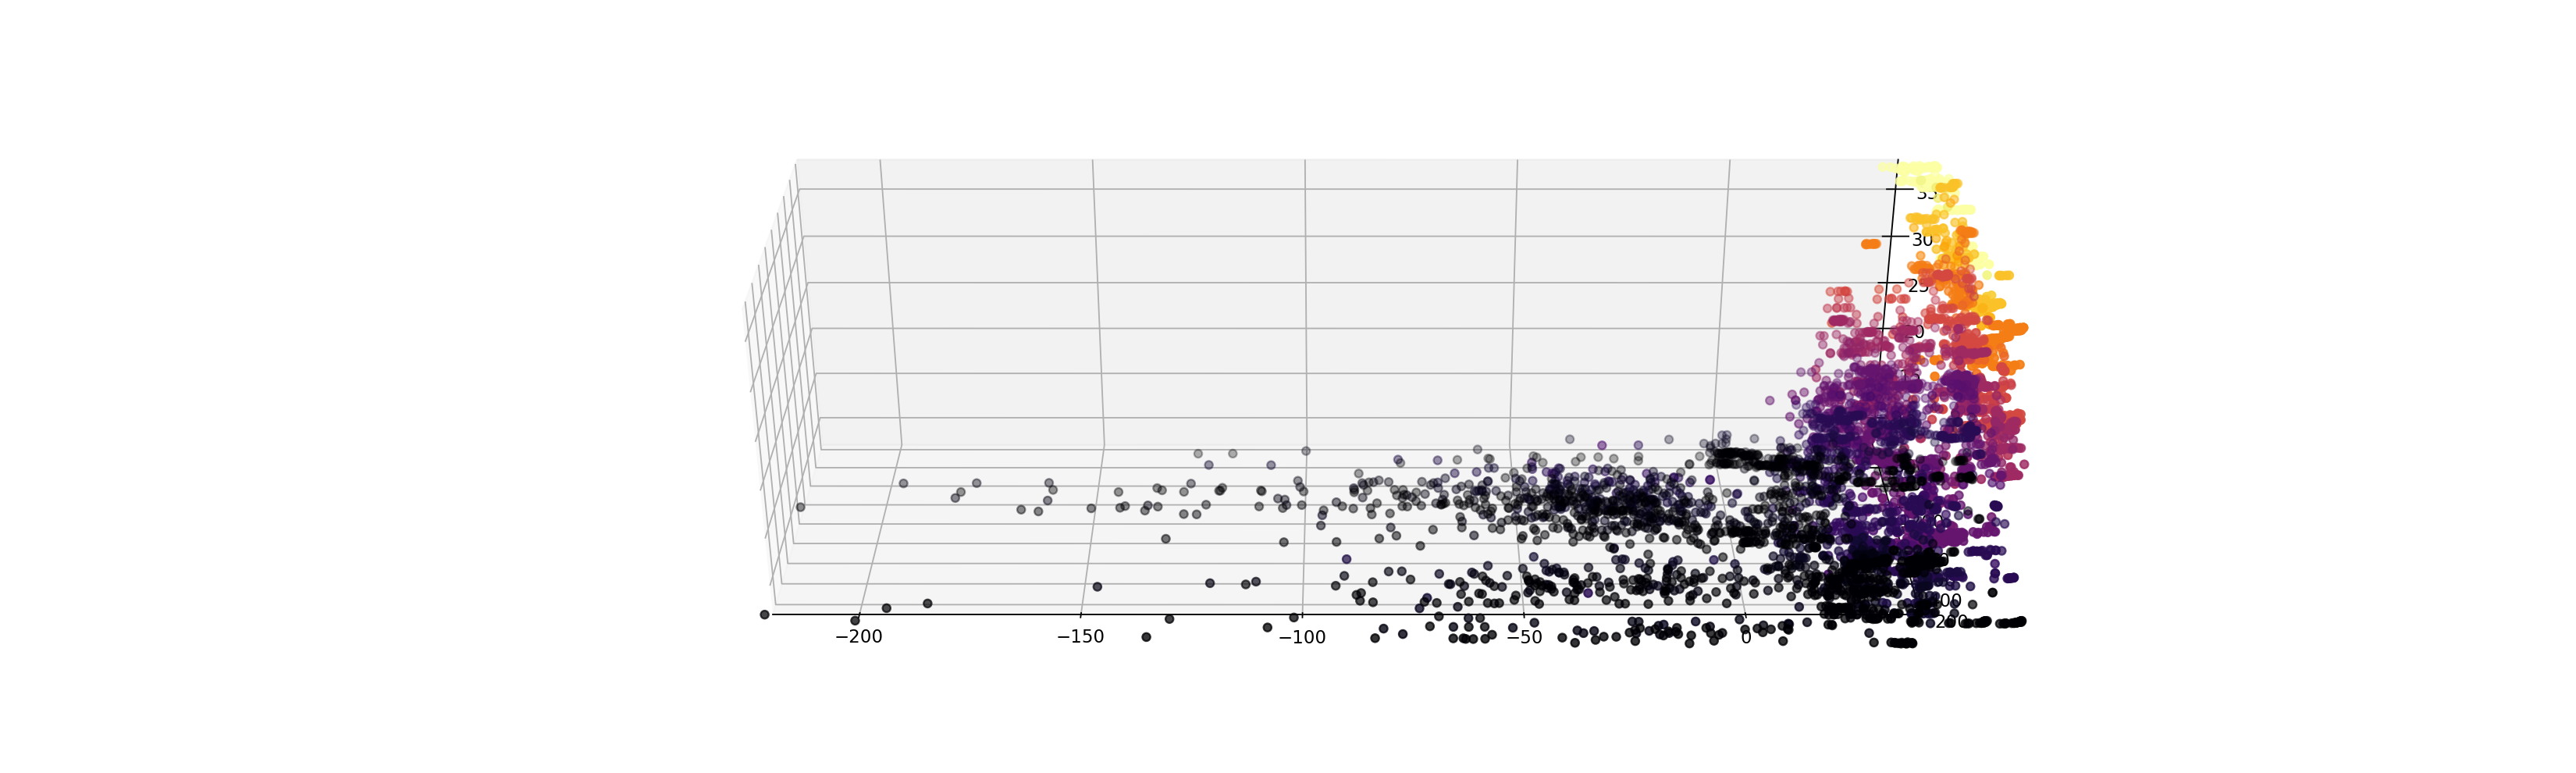

In [126]:
cfg = json.loads(json_config, object_hook = as_config)
result_book = App().run()
hist_over_time(result_book)

7891
5371 = 5371 = 5371
[5, 10, 10, 10, 5, 10, 10, 10, 5, 10]
[-62.15412843385305, 37.4243186079028, 29.39967802085048, 34.70648424242779, -94.97555233959646, 29.23350675968694, 36.406456675655065, 32.641781401310666, -78.44627852479314, 31.636278645817654]
[0, 0, 1, 2, 3, 3, 4, 5, 6, 6]


<IPython.core.display.Javascript object>


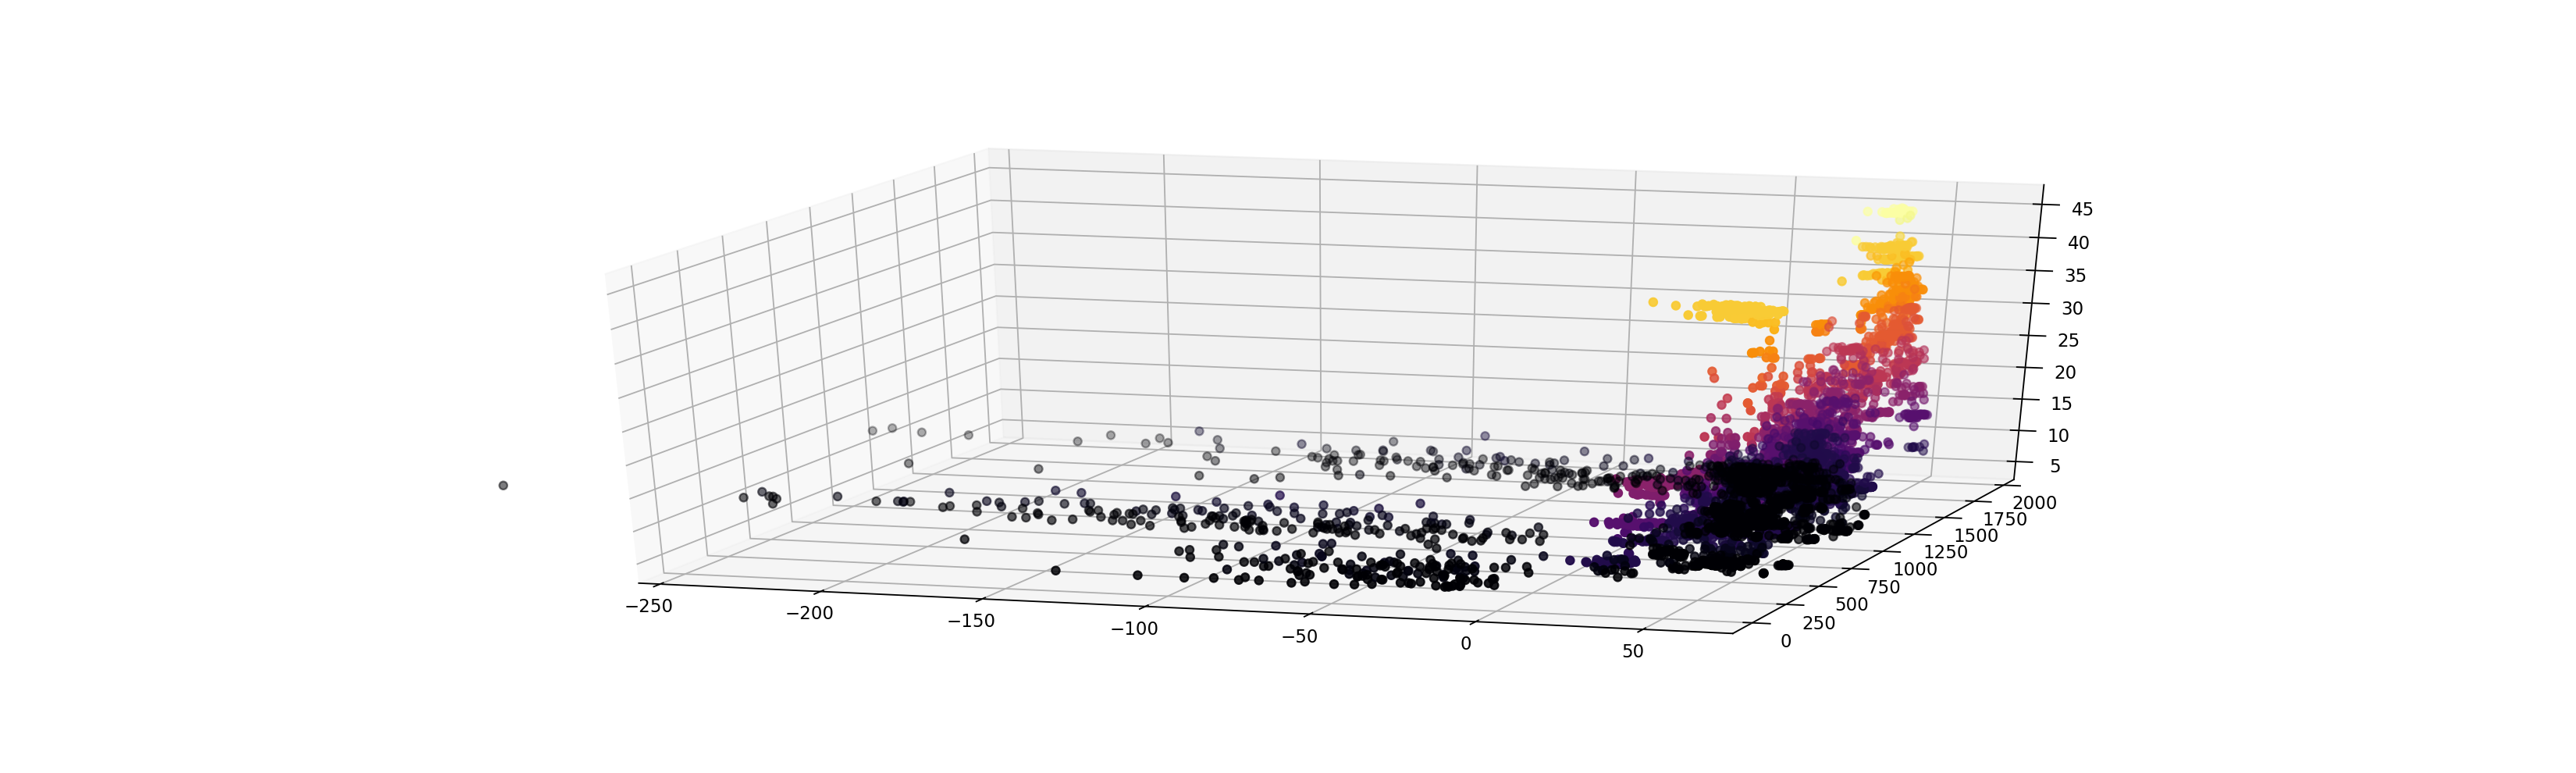

[-157.52107873 -117.91024999  -78.29942124  -38.6885925     0.92223625
   40.53306499]


<IPython.core.display.Javascript object>


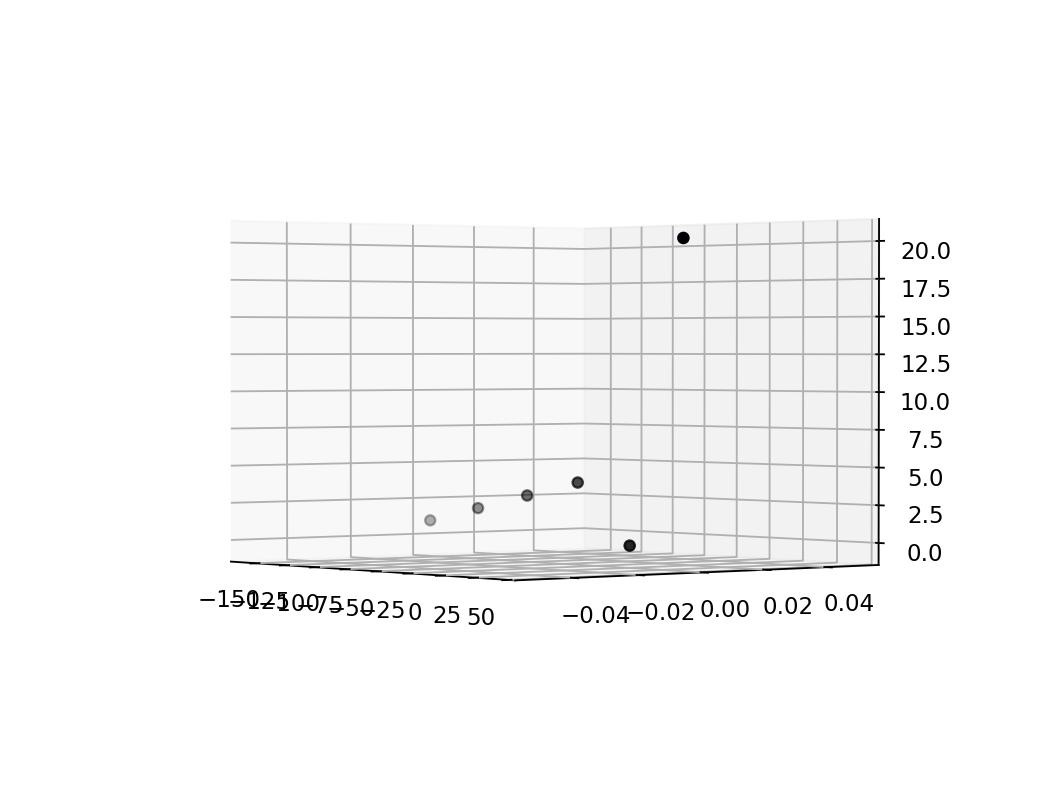

6 = 6 = 6


In [56]:
# print(len(result_book.select("hist")))
# hists = result_book.select("hist")
# hists = hists[100:] # skip first 100 evals
# hists = hists[0::4] # take one in 4
# hists = [h for h in hists if h]
# all_z_points = flatten([a[0].tolist() for a in hists])

# all_x_points = flatten([((a[1][1:] + a[1][:-1])/2).tolist() for a in hists])

# all_y_points = flatten([np.full(len(x[1]), x[0]) for x in [(a,hists[a][0]) for a in range(len(hists))]])
# size =  len(all_z_points)
# p = 0
# while p < size:
#     if all_z_points[p] < 5:
#         del all_z_points[p]
#         del all_x_points[p]
#         del all_y_points[p]
#         size = size - 1
#         p = p - 1
#     p = p + 1
# print(f"{len(all_z_points)} = {len(all_x_points)} = {len(all_y_points)}")
# print(all_z_points[0:10])
# print(all_x_points[0:10])
# print(all_y_points[0:10])
# fig = plt.figure(figsize=(20, 6), dpi=100)
# ax = plt.axes(projection="3d")
# ax.scatter3D(all_x_points, all_y_points, all_z_points, c=all_z_points, cmap='inferno');
# ax.set_xlim(-250, 70)
# plt.show()

# res = np.array(resultBook.select("hist")[1100])
# z_points = res[0]
# x_points = (res[1][1:] + res[1][:-1])/2
# print(x_points)
# y_points = np.zeros(len(z_points))
# fig = plt.figure()
# ax = plt.axes(projection="3d")
# print(f"{len(z_points)} = {len(x_points)} = {len(y_points)}")
# ax.scatter3D(x_points, y_points, z_points, c=y_points, cmap='inferno');
# plt.show()

<IPython.core.display.Javascript object>


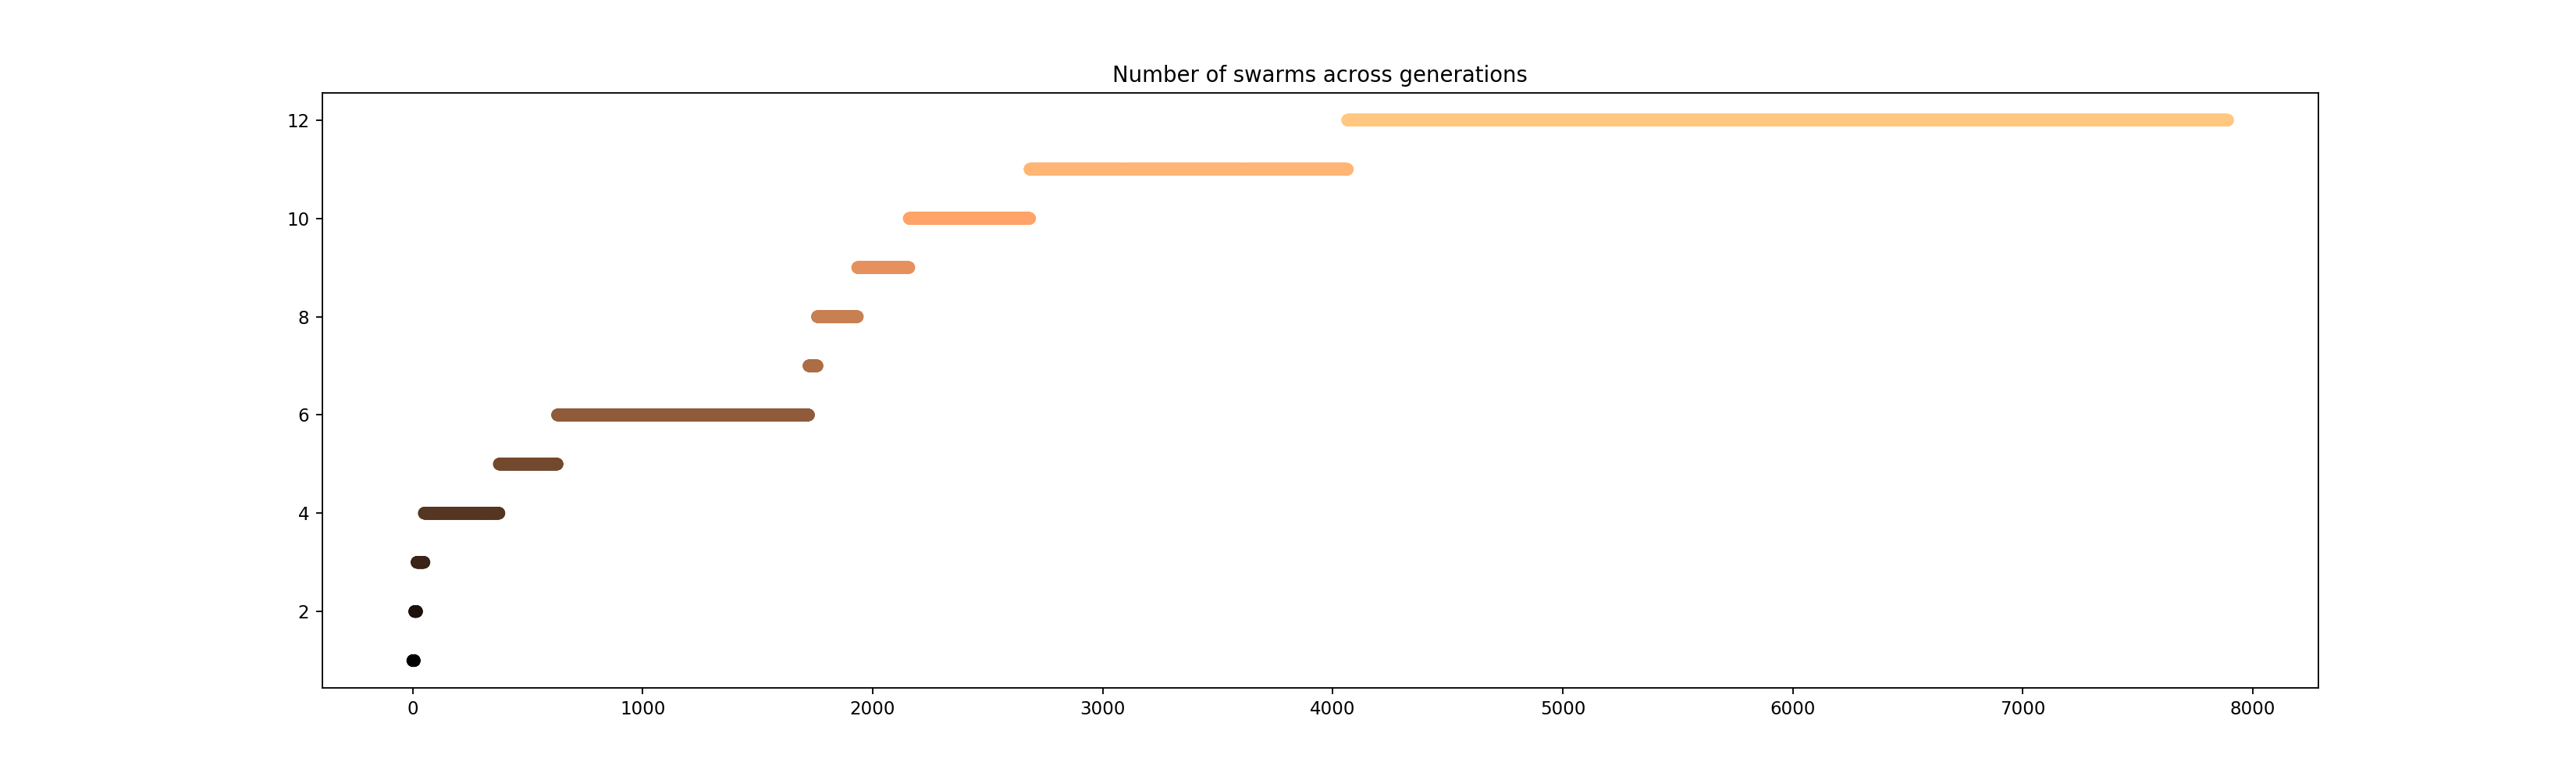

In [57]:
swarms = resultBook.select("nswarm")
swarms = [s for s in swarms]

fig = plt.figure(figsize=(20, 6), dpi=100)
ax = plt.axes(title="Number of swarms across generations")
ax.scatter(range(len(swarms)), swarms, c=swarms, cmap='copper');
plt.show()

<IPython.core.display.Javascript object>


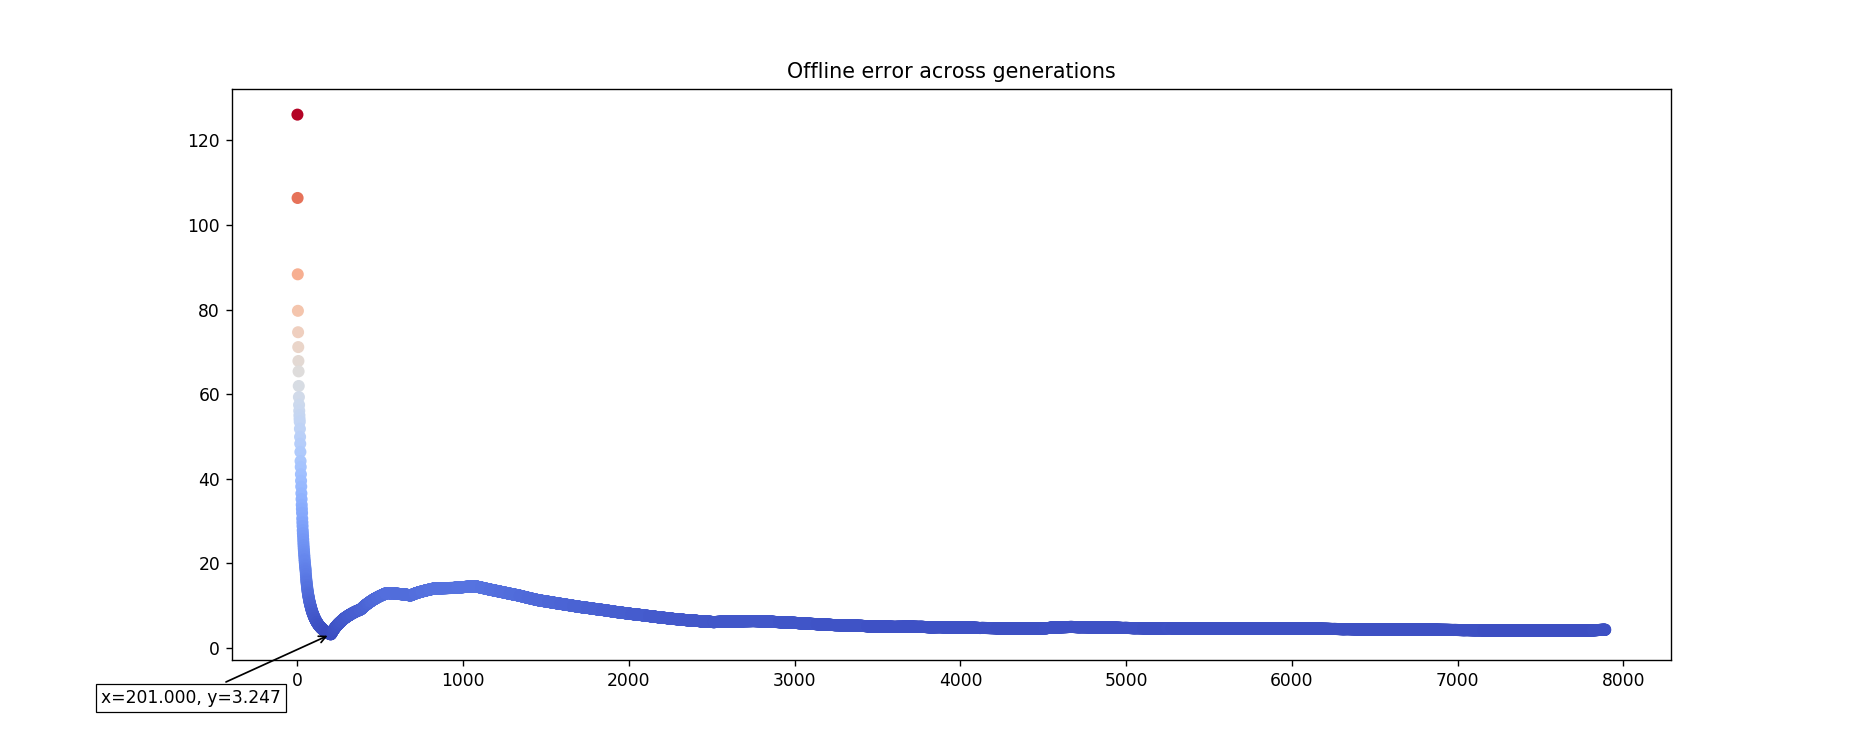

201 7891 0.025472056773539475


In [110]:
def annot_min(x,y, ax=None):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops,
              bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin/(len(x)*0.75),-0.05), **kw)

off_error = resultBook.select("offline_error")
off_error = np.array(off_error)

fig = plt.figure(figsize=(15, 6), dpi=75)
ax = plt.axes(title="Offline error across generations")
ax.scatter(range(len(off_error)), off_error, c=off_error, cmap='coolwarm');
annot_min(range(len(off_error)), off_error)
plt.show()

<IPython.core.display.Javascript object>


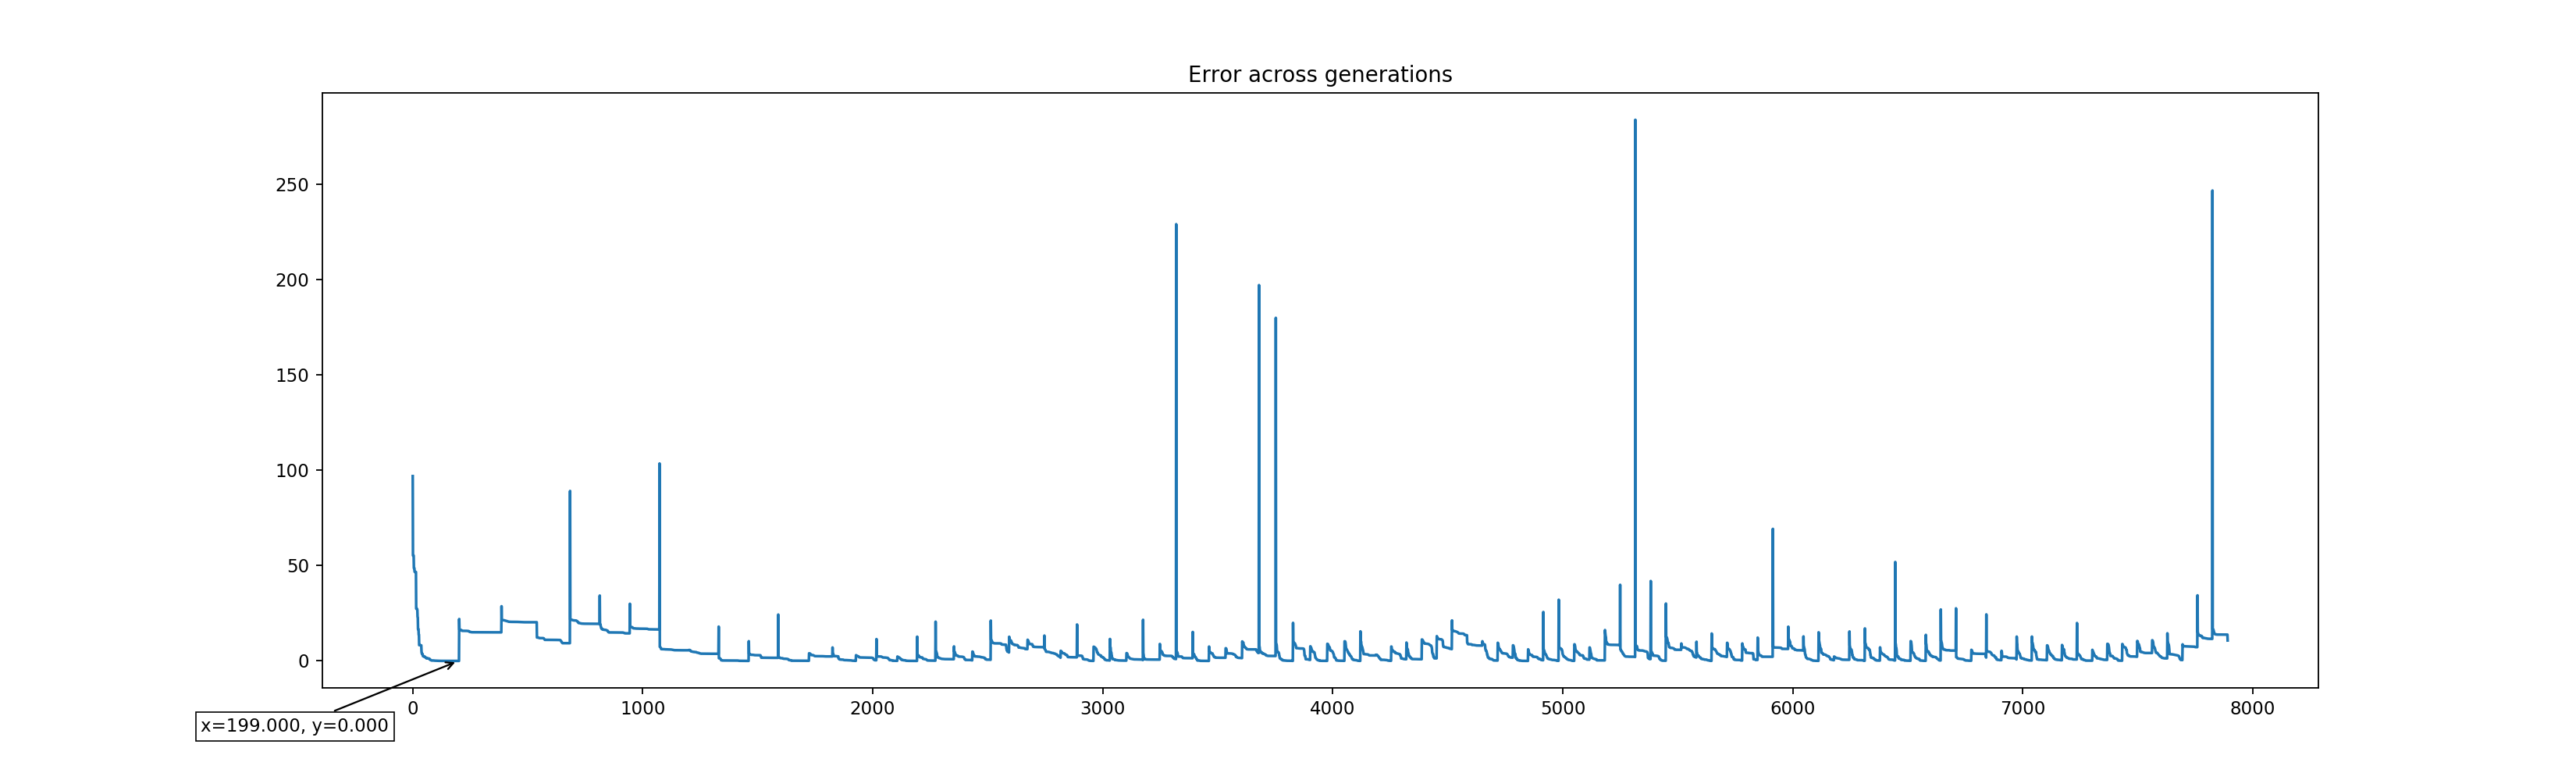

199 7891 0.02521860347231023


In [124]:
error = resultBook.select("error")
error = np.array(error)
fig = plt.figure(figsize=(20, 6), dpi=100)
ax = plt.axes(title="Error across generations")
# ax.scatter(range(len(error)), error, s=10, c=error, cmap='coolwarm')
ax.plot(range(len(error)), error)
annot_min(range(len(error)), error)
plt.show()

In [ ]:
# data_2d = [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#             [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
#             [11, 12, 13, 14, 15, 16, 17, 18 , 19, 20],
#             [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
#             [21, 22, 23, 24, 25, 26, 27, 28, 29, 30] ]
# print(np.array(resultBook.select("hist")).shape[1])
# print(np.array(resultBook.select("hist"))[0][1])
# d = np.array(resultBook.select("hist"))
# print(d)
# # np.meshgrid( np.arange(data_array.shape[1]),
# #                               np.arange(data_array.shape[0]) )
# #
# # Convert it into an numpy array.
# #
# data_array = np.array(data_2d)
# #
# # Create a figure for plotting the data as a 3D histogram.
# #
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# #
# # Create an X-Y mesh of the same dimension as the 2D data. You can
# # think of this as the floor of the plot.
# #
# x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
#                               np.arange(data_array.shape[0]) )
# #
# print(x_data)
# print(y_data)

# # Flatten out the arrays so that they may be passed to "ax.bar3d".
# # Basically, ax.bar3d expects three one-dimensional arrays:
# # x_data, y_data, z_data. The following call boils down to picking
# # one entry from each array and plotting a bar to from
# # (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
# #
# x_data = x_data.flatten()
# print(f"len: {len(x_data)}")
# x_data= np.random.randn(1, 50).flatten()
# y_data = y_data.flatten()
# print(y_data)
# z_data = data_array.flatten()
# ax.bar3d( x_data,
#           y_data,
#           np.zeros(len(z_data)),
#           1, 1, z_data )
# #
# # Finally, display the plot.
# #
# plt.show()